In [1]:
%load_ext autoreload

In [2]:
%autoreload
from mine.models.mine import Mine
import torch.nn as nn
import numpy as np
import torchvision
import torch
import torchvision.transforms as transforms
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from math import ceil
from einops import rearrange, repeat
from skimage.filters import gabor_kernel

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
print(device)

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224//5),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 1000


# USE 100K TEST DATA
dataset = torchvision.datasets.ImageFolder(
    root='/scratch/network/ls1546/imagenet/ILSVRC/Data/CLS-LOC/test', 
    transform=transform
)

# # load part of dataset
# indices = torch.arange(20000)
# dataset_half = torch.utils.data.Subset(dataset, indices)
# dataloader = torch.utils.data.DataLoader(dataset_half, batch_size=batch_size, shuffle=True, num_workers=2)

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

cuda:0


In [4]:
# create the gabor filter

image_dim = 224//5

results = []
kernel_params = []
for theta in (0, 1):
    theta = theta / 4. * np.pi
    for frequency in (0.006, 0.04):
        kernel = gabor_kernel(frequency, theta=theta)
        params = f"theta={theta * 180 / np.pi},\nfrequency={frequency:.3f}"
        kernel_params.append(params)
        # Save kernel and the power image for each image
        results.append(kernel)
results[3].shape, kernel_params[1]

((61, 61), 'theta=0.0,\nfrequency=0.040')

In [5]:
len(results)

4

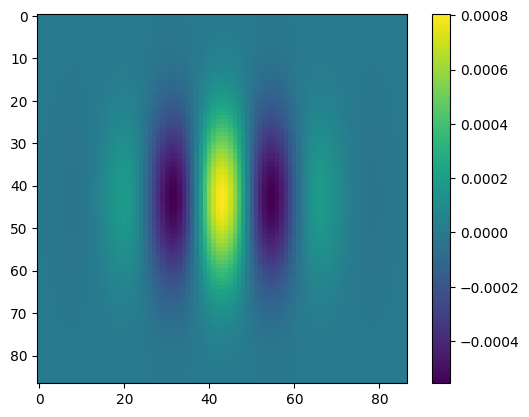

In [6]:
plt.figure()
plt.imshow(np.real(results[1]))
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()

In [7]:
image_dim = 224//5
input_height, input_width = results[1].shape

# Calculate cropping boundaries
crop_top = (input_height - image_dim) // 2
crop_bottom = crop_top + image_dim
crop_left = (input_width - image_dim) // 2
crop_right = crop_left + image_dim

# Perform the crop
weights1 = np.real(results[1])[crop_top:crop_bottom, crop_left:crop_right]

In [8]:
input_height, input_width = results[3].shape

# Calculate cropping boundaries
crop_top = (input_height - image_dim) // 2
crop_bottom = crop_top + image_dim
crop_left = (input_width - image_dim) // 2
crop_right = crop_left + image_dim

# Perform the crop
weights2 = np.real(results[3])[crop_top:crop_bottom, crop_left:crop_right]

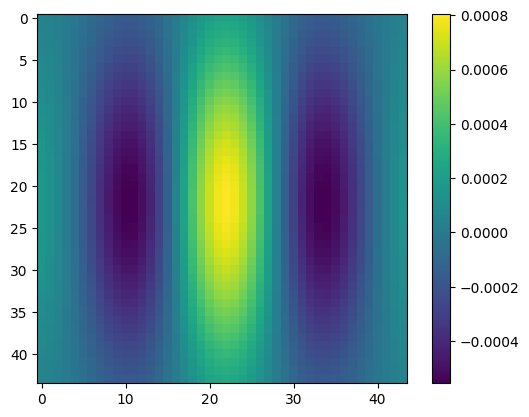

(44, 44)

In [9]:
plt.figure()
plt.imshow(weights1)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()
weights1.shape

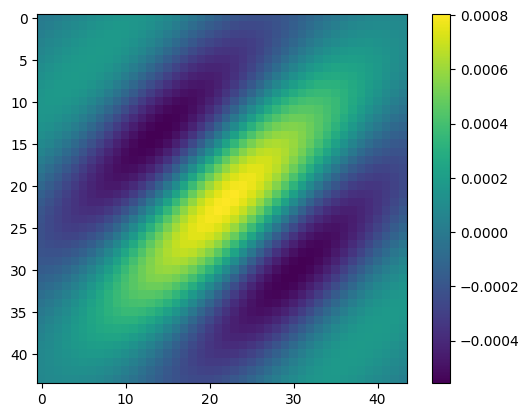

(44, 44)

In [10]:
plt.figure()
plt.imshow(weights2)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()
weights2.shape

In [11]:
def scale_rgb(x):
    return ((x - x.min()) / (x.max() - x.min()))

In [12]:
# scale weights
weights1 = scale_rgb(weights1)
weights2 = scale_rgb(weights2)

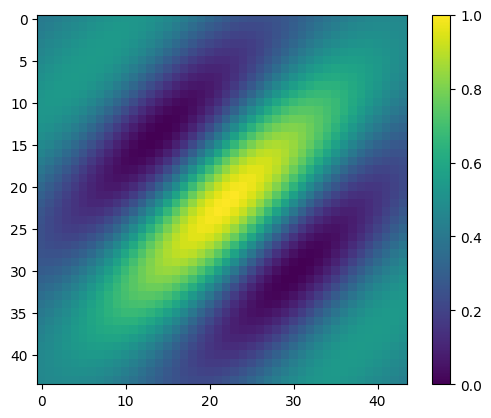

(44, 44)

In [13]:
plt.figure()
plt.imshow(weights2)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()
weights2.shape

In [14]:
# weights[44,44] -> [44,44,0] -> [44,44,3] -> [1,5808]
weights1 = torch.tensor(weights1, dtype=torch.float32)
flat_weights1 = np.repeat(weights1.unsqueeze(0), 3, axis=0).view(1, -1)
flat_weights1.shape

torch.Size([1, 5808])

In [15]:
weights2 = torch.tensor(weights2, dtype=torch.float32)
flat_weights2 = np.repeat(weights2.unsqueeze(0), 3, axis=0).view(1, -1)
flat_weights2.shape

torch.Size([1, 5808])

In [16]:
# plt.imshow(np.repeat(weights.unsqueeze(-1), 3, axis=-1).flatten().view(44, 44, 3))
x = flat_weights2.view(3, 224//5, 224//5)

In [19]:
x = flat_weights1.view(3, 224//5, 224//5)

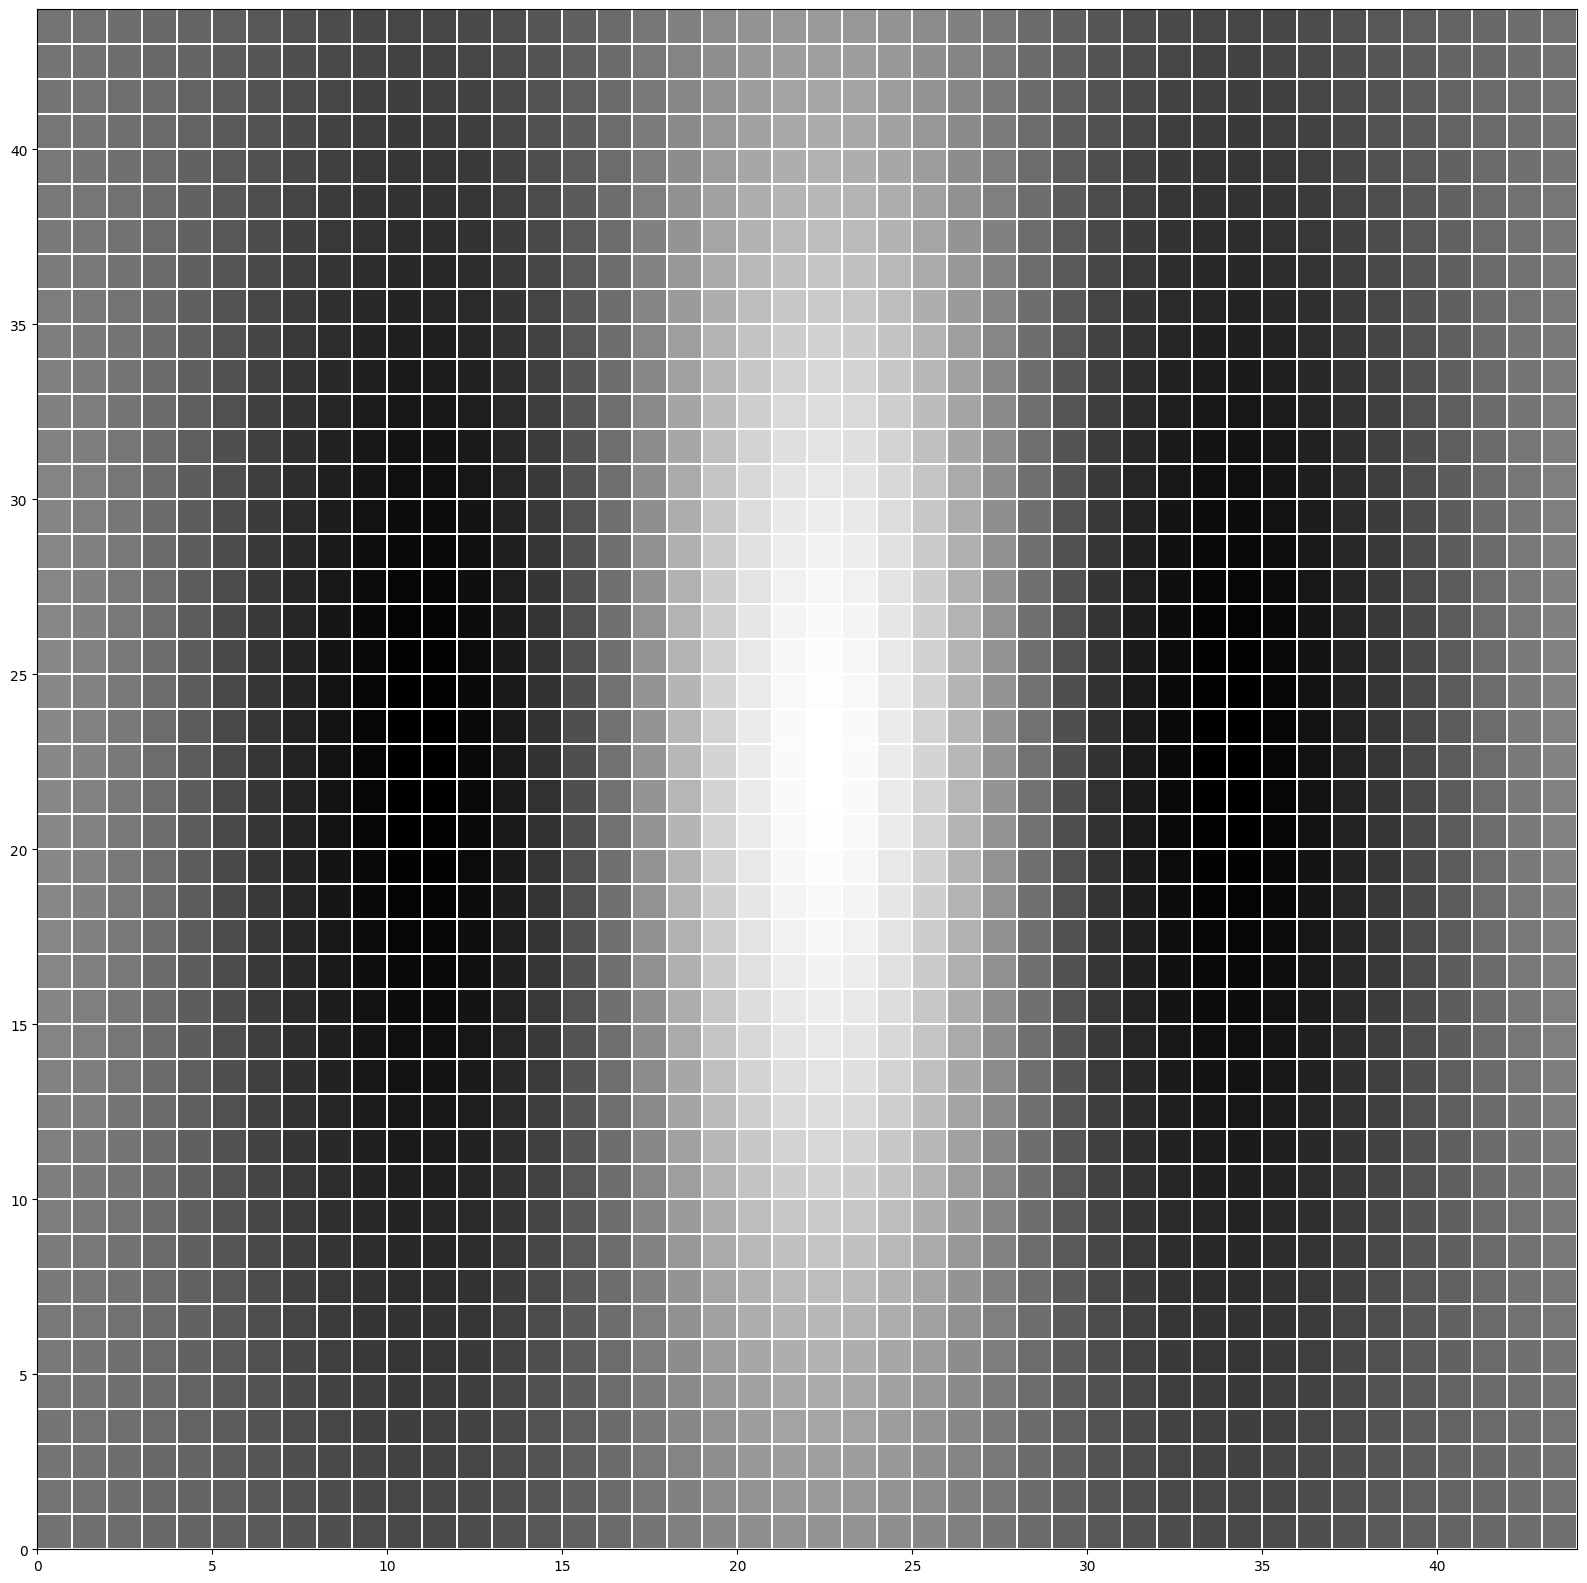

In [20]:
# weights are c w h
# need to flatten images in same way

plt.figure(figsize=(20,20))
plt.pcolormesh(np.transpose(np.array(list(map(scale_rgb, x))), (1,2,0)), edgecolors='w', linewidth=0.005)
# plt.pcolormesh(np.array(list(map(scale_rgb, x))), edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.show()

In [21]:
# pass images through toy_network to get activations
class Toynetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(image_dim*image_dim*3, 1)
        self.fc1.weight = torch.nn.Parameter(flat_weights1)
        self.fc2 = nn.Linear(image_dim*image_dim*3, 1)
        self.fc2.weight = torch.nn.Parameter(flat_weights2)

    def forward(self, input):
        x = F.relu(self.fc1(input))
        y = F.relu(self.fc2(input))
        return x + y

In [22]:
toy_net = Toynetwork().to(device)

In [23]:
test = next(iter(dataloader))

In [24]:
test[0].shape
# images c w h

torch.Size([1000, 3, 44, 44])

In [27]:
toy_net

Toynetwork(
  (fc1): Linear(in_features=5808, out_features=1, bias=True)
  (fc2): Linear(in_features=5808, out_features=1, bias=True)
)

In [28]:
# add hooks, run model with inputs to get activations

# a dict to store the activations
activation = {}
def get_activation(name):
    # the hook signature
    def hook(model, input, output):
        activation[name] = output.detach().cpu().numpy()
        
    return hook

hook = toy_net.fc1.register_forward_hook(get_activation('fc1'))

In [30]:
inputs_list = []
act_list = []

for inputs, _ in tqdm(dataloader):
    inputs = torch.flatten(inputs, start_dim=1)
    inputs = inputs.to(device)

    with torch.no_grad():
        output = toy_net(inputs)
        
        # collect the activations
        act_list.append(activation['relu'])

        inputs = inputs.detach().cpu().numpy()
        inputs_list.append(inputs)

    del inputs

# detach the hooks
hook.remove()

100%|███████████████████████████████████████| 100/100 [00:48<00:00,  2.06it/s]


In [ ]:
# send X=input images, Y=neuron responses to inputs into MINE, T's weights
# at 1st layer for X should approximate the  weights in toy_net

In [ ]:
act_length = (len(act_list) - 1)*batch_size + len(act_list[len(act_list)-1])
act_length, len(act_list), act_list[0].shape, inputs_list[0].shape, inputs_list[-1].shape

In [ ]:
x = inputs_list[-1].copy()
x

In [ ]:
print(x.shape)
x = np.reshape(x[-1], (3, 224//5, 224//5))
print(x.shape)

In [ ]:
x[0] = scale_rgb(x[0])
x[1] = scale_rgb(x[1])
x[2] = scale_rgb(x[2])
plt.imshow(np.transpose(x, (1,2,0)))

In [ ]:
samples = (len(inputs_list) - 1)*batch_size + len(inputs_list[len(inputs_list)-1])
images_flat = np.zeros((samples, (224//5)*(224//5)*3))
responses = np.zeros((act_length, 1))
x_dim=(224//5)*(224//5)*3
y_dim=1

for batch in range(len(act_list)):
    for image in range(len(act_list[batch])):
        responses[batch*len(act_list[0])+image, 0] = act_list[batch][image, 0]
        images_flat[batch*len(act_list[0])+image, :] = inputs_list[batch][image]

In [ ]:
samples, act_length

In [ ]:
y = images_flat[-1].copy()
y.shape

In [ ]:
y = np.reshape(y, (3, 224//5, 224//5))
y[0] = scale_rgb(y[0])
y[1] = scale_rgb(y[1])
y[2] = scale_rgb(y[2])
plt.imshow(np.transpose(y, (1,2,0)))

In [ ]:
del act_list, inputs_list

In [ ]:
class Image_network(nn.Module):
    def __init__(self, x_dim, y_dim):
        super().__init__()
        self.fc1x = nn.Linear(x_dim, 1, bias=False)
        self.fc1y = nn.Linear(y_dim, 1, bias=False)
        self.fc2 = nn.Linear(2, 100, bias=False)
        self.fc3 = nn.Linear(100, 1, bias=False)

    def forward(self, x, y):
        x = F.relu(self.fc1x(x))
        y = F.relu(self.fc1y(y))
        h = torch.cat((x, y), dim=1)
        h = F.relu(self.fc2(h))
        h = self.fc3(h)
        return h

In [ ]:
device

In [ ]:
# image_network = torch.compile(image_network)
# print(device)
mine = Mine(
    T = Image_network(x_dim, y_dim),
    loss = 'mine', #mine_biased, fdiv
    device = device
).to(device)
lam = 0.005
mi, loss_list = mine.optimize(
    X=torch.tensor(images_flat, dtype=torch.float32), 
    Y=torch.tensor(responses, dtype=torch.float32), 
    epochs=500, 
    batch_size=batch_size, 
    lam=lam,
)

In [ ]:
lam_str = str(lam)
lam_str

In [ ]:
plt.figure()
plt.plot(torch.stack(loss_list).detach().cpu().numpy())
plt.title("loss: gabor, 500 epochs, lambda="+lam_str)
# plt.title("loss: square, 1000 epochs, lambda="+lam_str)
plt.ylabel("loss")
plt.xlabel("batches")
# plt.show()
plt.savefig("lossgabor"+lam_str+".pdf")
# plt.savefig("losssq"+lam_str+".pdf")

In [ ]:
Tweights = mine.T.fc1x.weight.detach().cpu().numpy()[0]
Tweights.shape

In [ ]:
unflat_Tweights = np.reshape(Tweights, (3,224//5,224//5))
unflat_Tweights.shape

In [ ]:
for i in range(3):
    # plt.clf()
    plt.figure()
    plt.pcolormesh(scale_rgb(unflat_Tweights[i]), edgecolors="k", linewidth=0.005)
    ax = plt.gca()
    ax.set_aspect("equal")
    plt.colorbar()
    plt.title(f"gabor, lambda={lam_str}, channel {i}")
    plt.savefig(f"Tweightsc{i}{lam_str}gabor.pdf")

In [ ]:
plt.figure()
plt.imshow(weights)
ax = plt.gca()
ax.set_aspect('equal')
plt.colorbar()
plt.show()
weights.shape

In [ ]:
plt.pcolormesh(np.transpose(np.array(list(map(scale_rgb, unflat_Tweights))), (1,2,0)), edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.title("gabor T weights combined channels, lambda="+lam_str)
plt.savefig("Tweightscombgabor" + lam_str + ".pdf")

plt.figure()
plt.pcolormesh(np.transpose(np.array(list(map(scale_rgb, flat_weights.view(3, 44, 44)))), (1,2,0)), edgecolors='k', linewidth=0.005)
# plt.pcolormesh(np.array(list(map(scale_rgb, x))), edgecolors='k', linewidth=0.005)
ax = plt.gca()
ax.set_aspect('equal')
plt.show()

In [ ]:
np.save('images_flat_lam_gabor.npy', images_flat)
np.save('responses_lam_gabor.npy', responses)

In [ ]:
torch.save(mine.T, "mineTgabor" + lam_str + ".pth")
np.save("migabor" + lam_str + ".npy", mi.detach().cpu().numpy())
np.save("lossgabor" + lam_str + ".npy", torch.stack(loss_list).detach().cpu().numpy())

In [ ]:
mi = float(mi)

In [ ]:
mi

In [ ]:
loss_list = np.load("/scratch/network/ls1546/mine-pytorch/scripts/lossgaborfull0.005.npy")

In [ ]:
!pwd